# General Overview - Machine Learning

### Import and Load

In [6]:
# for basic operations
import numpy as np 
import pandas as pd 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
# rcParams['figure.figsize'] = 4,4
# plt.style.use('fivethirtyeight')

from collections import Counter

# for modeling 
import sklearn
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [7]:
data = pd.read_csv('diabetic_data_cleaned_dummy.csv', index_col=0)
df = data.copy()

df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,race_Hispanic,...,rosiglitazone_No,rosiglitazone_Up,acarbose_Steady,acarbose_Up,insulin_No,insulin_Steady,insulin_Up,change_No,diabetesMed_Yes,readmitted_YES
0,3,59,0,18,0,0,9,0,1,0,...,1,0,0,0,0,0,1,0,1,1
1,2,11,5,13,2,1,6,0,0,0,...,1,0,0,0,1,0,0,1,1,0
2,2,44,1,16,0,0,7,0,1,0,...,1,0,0,0,0,0,1,0,1,0
3,1,51,0,8,0,0,5,0,1,0,...,1,0,0,0,0,1,0,0,1,0
4,3,31,6,16,0,0,9,0,1,0,...,1,0,0,0,0,1,0,1,1,1


### Lazy Predict with 5000 samples

In [8]:
# from lazypredict.Supervised import LazyClassifier

# df_5000 = df.sample(5000,random_state=42)
# y = df_5000['readmitted_YES']
# X = df_5000.drop('readmitted_YES', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state =42)

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

### Split Data

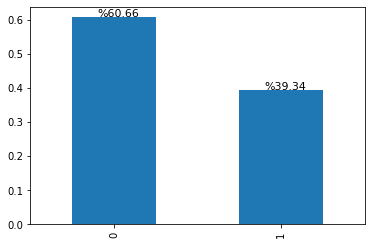

In [9]:
ax = df['readmitted_YES'].value_counts(normalize=True).plot.bar()
def labels(ax):
    for p in ax.patches:
        ax.annotate(f"%{p.get_height()*100:.2f}", (p.get_x() + 0.15, p.get_height() * 1.005),size=11)
labels(ax)

In [10]:
# separating the dependent and independent data
X = df.drop('readmitted_YES', axis=1)
y = df['readmitted_YES']

# the function train_test_split creates random data samples (default: 75-25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# getting the shapes
print(f"""shape of X_train: {X_train.shape}
shape of X_test\t: {X_test.shape}
shape of y_train: {y_train.shape}
shape of y_test\t: {y_test.shape}""")

shape of X_train: (48296, 54)
shape of X_test	: (16099, 54)
shape of y_train: (48296,)
shape of y_test	: (16099,)


### Data Scaling

In [11]:
# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Iteration 1: (Unbalanced data)
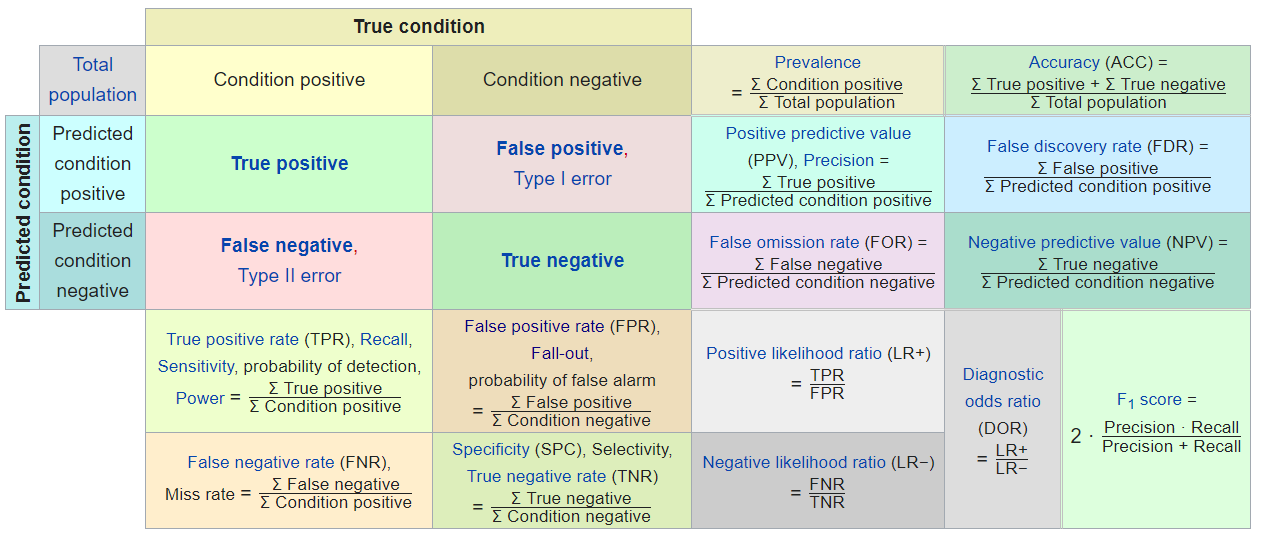

In [12]:
cv_acc_train = {}
cv_acc_test = {}
cv_TPR = {}
cv_FPR = {}
cv_AUC = {}

In [13]:
def plot_result(model, name:str):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')  
    cv_acc_train[name] = round(scores_train.mean(), 4)*100  # balanced accuracy
    cv_acc_test[name] = round(scores_test.mean(), 4)*100  # balanced accuracy
    cv_TPR[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (Max)
    cv_FPR[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (Min)
    
    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

### 1-Decision tree

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

Average Balanced Accuracy (CV=10), Test Set: 0.5223535508165191
Average Balanced Accuracy (CV=10), Training Set:  0.5227271817899852
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      9766
           1       0.42      0.42      0.42      6333

    accuracy                           0.54     16099
   macro avg       0.52      0.52      0.52     16099
weighted avg       0.54      0.54      0.54     16099



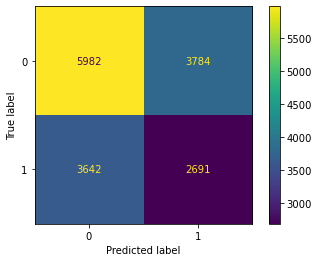

In [15]:
dtc = DecisionTreeClassifier()
plot_result(dtc, "dtc")

In [16]:
# plot tree
# plt.figure(figsize=(16,6))
# plot_tree(dtc, filled = True, class_names=["-1", "1"], feature_names=X.columns, fontsize=11);

In [17]:
cv_acc_train, cv_acc_test, cv_TPR, cv_FPR

({'dtc': 52.27},
 {'dtc': 52.239999999999995},
 {'dtc': 42.49171009000474},
 {'dtc': 38.74667212779029})

### 2-Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression()
plot_result(lr, "lr")

### 3-SVC

In [ ]:
# svc = SVC(probability=True)  # default values
# plot_result(svc, "svc")

### 4-NearestCentroid

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix

In [ ]:
nc = NearestCentroid()
plot_result(nc, "nc")

### 5-Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()
plot_result(rfc, "rfc")

In [ ]:
def plot_feature_importances(model):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:10]

    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

    print(f"Top 10 Feature Importance for {str(model).split('(')[0]}\n\n",feature_imp[:10],sep='')

In [ ]:
plot_feature_importances(rfc)

### 6-Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbc = GradientBoostingClassifier(random_state=42)
plot_result(gbc, "gbc")

In [ ]:
plot_feature_importances(gbc)

### 7-Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()
plot_result(nb, "nb")

### 8-kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier()
plot_result(knn, "knn")

### 9-XGBOOST

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

In [ ]:
xgb = XGBClassifier(eval_metric = "logloss")
plot_result(xgb, "xgb")

In [ ]:
plot_feature_importances(xgb)

In [ ]:
from xgboost import plot_importance
plot_importance(xgb,max_num_features=10)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

### Evaluation (iteration 1)

In [38]:

def AUC(cv_AUC, X_test=X_test):
    dtc_auc= roc_auc_score(y_test,dtc.predict(X_test)) #Decision Tree Classifier
    lr_auc= roc_auc_score(y_test, lr.decision_function(X_test))#logistic regression
#     svc_auc= roc_auc_score(y_test, svc.decision_function(X_test))#Support Vector Classifier
    nc_auc= roc_auc_score(y_test, nc.predict(X_test))#Nearest Centroid Classifier
    rfc_auc= roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])#Randomforest Classifier
    gbc_auc= roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])#GradientBoosting Classifier
    nb_auc= roc_auc_score(y_test, nb.predict_proba(X_test)[:,1])#Naive Bayes Classifier
    knn_auc= roc_auc_score(y_test, knn.predict(X_test))#KNeighbors Classifier
    xgb_auc= roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])#XGBoost Classifier

    cv_AUC={'dtc': dtc_auc,
           'lr': lr_auc,
#            'svc':svc_auc,
           'nc':nc_auc,
           'rfc':rfc_auc,
           'gbc':gbc_auc,
           'nb':nb_auc,
           'knn':knn_auc,
           'xgb':xgb_auc}
    return cv_AUC

In [39]:
cv_AUC = AUC(cv_AUC)
df_eval = pd.DataFrame(data={'model': list(cv_acc_test.keys()), 
                             'bal_acc_train':list(cv_acc_train.values()),
                             'bal_acc_test': list(cv_acc_test.values()), 
                             'recall': list(cv_TPR.values()), 
                             'fallout':list(cv_FPR.values()),
                              'AUC': list(cv_AUC.values())}).round(2)
df_eval

,model,bal_acc_train,bal_acc_test,recall,fallout,AUC
0,dtc,52.27,52.24,42.49,38.75,0.52
1,lr,54.45,54.19,18.35,9.52,0.61
2,nc,57.32,56.99,55.01,41.13,0.57
3,rfc,55.15,54.40,26.65,16.70,0.59
4,gbc,54.63,54.58,17.59,8.17,0.62
5,nb,56.29,51.44,36.29,23.92,0.59
6,knn,53.67,52.08,33.87,27.89,0.53
7,xgb,55.92,54.88,27.51,16.52,0.61


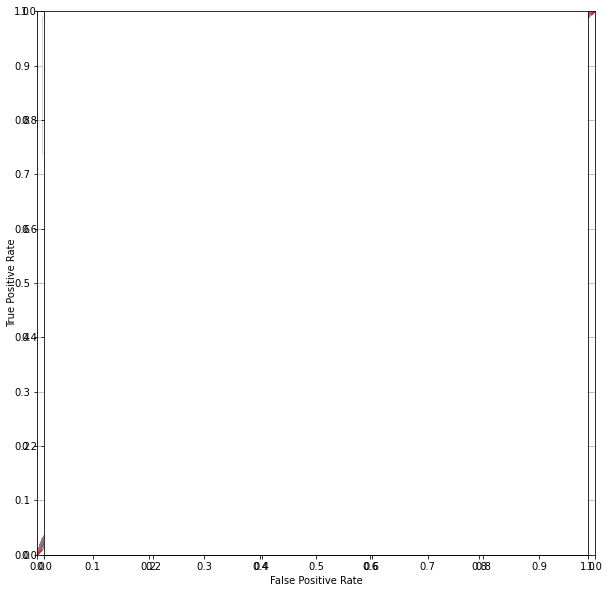

In [40]:
def plot_ROC(X_test=X_test, y_test=y_test):
    fpr_dtc, tpr_dtc, thresholds = roc_curve(y_test,dtc.predict(X_test)) #Decision Tree Classifier
    fpr_lr, tpr_lr, thresholds = roc_curve(y_test, lr.decision_function(X_test))#logistic regression
#     fpr_svc, tpr_svc, thresholds = roc_curve(y_test, svc.decision_function(X_test))#Support Vector Classifier
    fpr_nc, tpr_nc, thresholds = roc_curve(y_test, nc.predict(X_test))#Nearest Centroid Classifier
    fpr_rfc, tpr_rfc, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])#Randomforest Classifier
    fpr_gbc, tpr_gbc, thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])#GradientBoosting Classifier
    fpr_nb, tpr_nb, thresholds = roc_curve(y_test, nb.predict_proba(X_test)[:,1])#Naive Bayes Classifier
    fpr_knn, tpr_knn, thresholds = roc_curve(y_test, knn.predict(X_test))#KNeighbors Classifier
    fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])#XGBoost Classifier

    #compare the ROC curve between different models
    plt.figure(figsize=(10,10))
    plt.plot(fpr_dtc, tpr_dtc, label='Decision Tree Classifier')
    plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
#     plt.plot(fpr_svc, tpr_svc, label='Support Vector Classifier')
    plt.plot(fpr_nc, tpr_nc, label='Nearest Centroid Classifier')
    plt.plot(fpr_rfc, tpr_rfc, label='Randomforest Classifier')
    plt.plot(fpr_gbc, tpr_gbc, label='GradientBoosting Classifier')
    plt.plot(fpr_nb, tpr_nb, label='Naive Bayes Classifier')
    plt.plot(fpr_knn, tpr_knn, label='KNeighbors Classifier')
    plt.plot(fpr_xgb, tpr_xgb, label='XGBoost Classifier')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='random', alpha=.8)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.grid()
    plt.legend()
    plt.axes().set_aspect('equal')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_ROC()

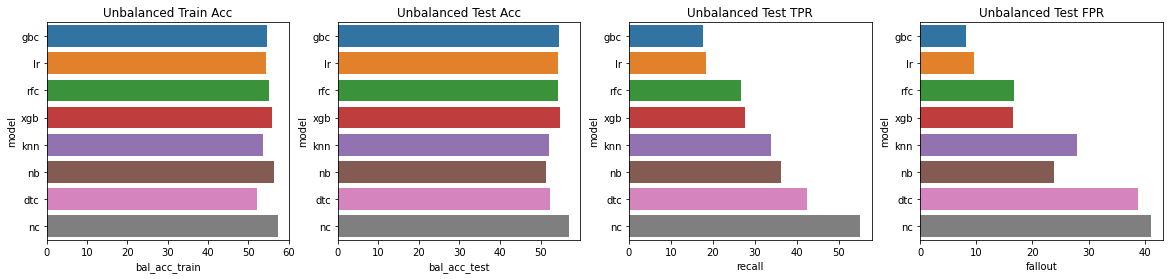

In [41]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))
sns.barplot(x="bal_acc_train", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0])
ax[0].set_title("Unbalanced Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval.sort_values(by="recall"), ax=ax[1])
ax[1].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[2])
ax[2].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[3])
ax[3].set_title("Unbalanced Test FPR")
plt.show()

> NaiveBayes gave high BalanceAccuracy and TPR_Score (Recall), but it gave the poor FPR_Score (Fallout) in this unbalanced data set.

### Iteration 2: (Oversampling with SMOTE)

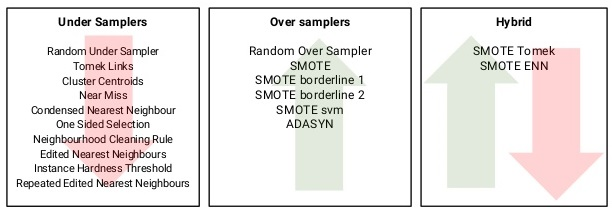

### Balancing data

In [42]:
y_test.value_counts(normalize=True)

0    0.606622
1    0.393378
Name: readmitted_YES, dtype: float64

In [43]:
y_train.value_counts(normalize=True)

0    0.606613
1    0.393387
Name: readmitted_YES, dtype: float64

In [44]:
# pip install imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [45]:
oversmote = SMOTE()
X_train_os, y_train_os= oversmote.fit_resample(X_train, y_train)

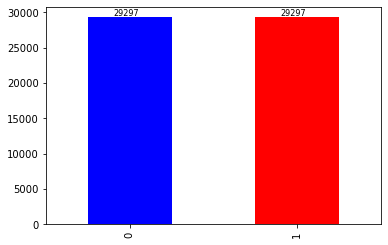

In [46]:
ax = y_train_os.value_counts().plot.bar(color=["blue", "red"])
def labels(ax):
    for p in ax.patches:
        ax.annotate(f"{p.get_height()}", (p.get_x() + 0.15, p.get_height()+200),size=8)
labels(ax)
plt.show()

In [47]:
X_train_os.shape

(58594, 54)

### Use algorithms

In [48]:
cv_acc_balance_train = {}
cv_acc_balance_test = {}
cv_TPR_balance = {}
cv_FPR_balance = {}
cv_AUC_balance = {}

In [49]:
def plot_result_smote(model, name:str):
    model.fit(X_train_os, y_train_os)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_train[name] = round(scores_train.mean(), 4)*100  # balanced accuracy
    cv_acc_balance_test[name] = round(scores_test.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    
    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

Average Balanced Accuracy (CV=10), Test Set: 0.518304595406007
Average Balanced Accuracy (CV=10), Training Set:  0.5215033405861726
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      9766
           1       0.42      0.43      0.43      6333

    accuracy                           0.54     16099
   macro avg       0.52      0.52      0.52     16099
weighted avg       0.55      0.54      0.54     16099



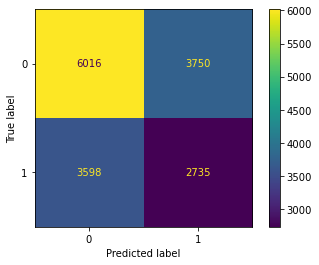

In [50]:
# Decision tree
dtc = DecisionTreeClassifier()

plot_result_smote(dtc, "dtc")

Average Balanced Accuracy (CV=10), Test Set: 0.5419498087033714
Average Balanced Accuracy (CV=10), Training Set:  0.544459039736215
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      9766
           1       0.47      0.56      0.51      6333

    accuracy                           0.58     16099
   macro avg       0.57      0.57      0.57     16099
weighted avg       0.59      0.58      0.58     16099



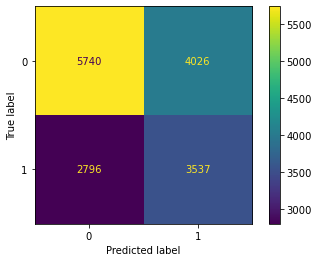

In [51]:
# Logistic Regression
lr = LogisticRegression()
plot_result_smote(lr, "lr")

Average Balanced Accuracy (CV=10), Test Set: 0.5698805954350324
Average Balanced Accuracy (CV=10), Training Set:  0.5731634513693644
              precision    recall  f1-score   support

           0       0.67      0.58      0.62      9766
           1       0.46      0.56      0.51      6333

    accuracy                           0.57     16099
   macro avg       0.57      0.57      0.57     16099
weighted avg       0.59      0.57      0.58     16099



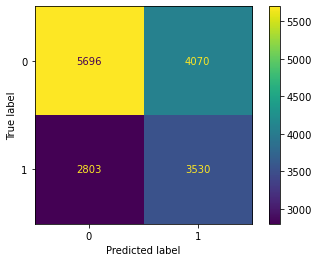

In [52]:
# NearestCentroid
nc = NearestCentroid()
plot_result_smote(nc, "nc")

In [53]:
# # SVC
# svc = SVC()
# plot_result_smote(svc, "svc")

Average Balanced Accuracy (CV=10), Test Set: 0.5444895342228483
Average Balanced Accuracy (CV=10), Training Set:  0.5519687112559144
              precision    recall  f1-score   support

           0       0.64      0.79      0.71      9766
           1       0.50      0.32      0.39      6333

    accuracy                           0.61     16099
   macro avg       0.57      0.56      0.55     16099
weighted avg       0.59      0.61      0.58     16099



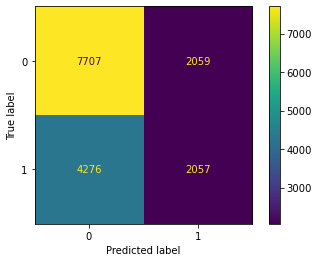

In [54]:
# Random Forest
rfc = RandomForestClassifier()
plot_result_smote(rfc, "rfc")

Average Balanced Accuracy (CV=10), Test Set: 0.5457854180520995
Average Balanced Accuracy (CV=10), Training Set:  0.5462612337448516
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      9766
           1       0.52      0.30      0.38      6333

    accuracy                           0.62     16099
   macro avg       0.58      0.56      0.55     16099
weighted avg       0.59      0.62      0.59     16099



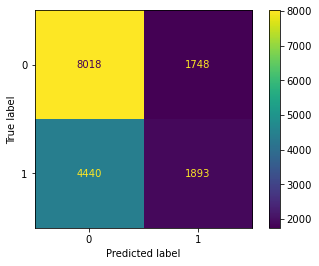

In [55]:
# Gradient Boost
gbc = GradientBoostingClassifier(random_state=42)
plot_result_smote(gbc, "gbc")

Average Balanced Accuracy (CV=10), Test Set: 0.5144278553940823
Average Balanced Accuracy (CV=10), Training Set:  0.5629375730757987
              precision    recall  f1-score   support

           0       0.66      0.71      0.68      9766
           1       0.49      0.43      0.45      6333

    accuracy                           0.60     16099
   macro avg       0.57      0.57      0.57     16099
weighted avg       0.59      0.60      0.59     16099



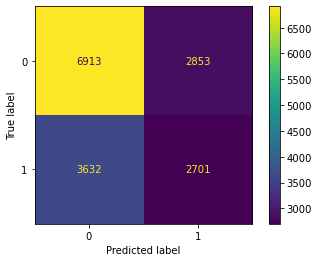

In [56]:
# Naive Bayes
nb = GaussianNB()
plot_result_smote(nb, "nb")

Average Balanced Accuracy (CV=10), Test Set: 0.5208351489946321
Average Balanced Accuracy (CV=10), Training Set:  0.5367488083809042
              precision    recall  f1-score   support

           0       0.64      0.54      0.58      9766
           1       0.42      0.52      0.47      6333

    accuracy                           0.53     16099
   macro avg       0.53      0.53      0.53     16099
weighted avg       0.55      0.53      0.54     16099



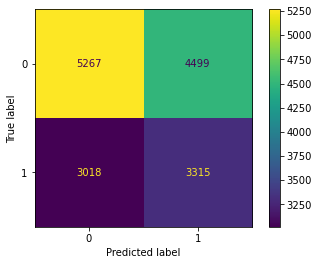

In [57]:
# kNN
knn = KNeighborsClassifier()
plot_result_smote(knn, "knn")

Average Balanced Accuracy (CV=10), Test Set: 0.548751906115082
Average Balanced Accuracy (CV=10), Training Set:  0.5591727365490434
              precision    recall  f1-score   support

           0       0.64      0.84      0.73      9766
           1       0.53      0.28      0.37      6333

    accuracy                           0.62     16099
   macro avg       0.58      0.56      0.55     16099
weighted avg       0.60      0.62      0.58     16099



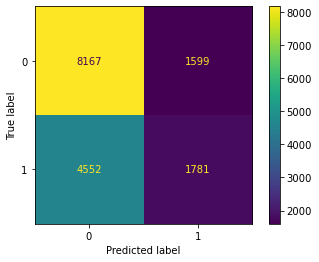

In [58]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss", random_state=42)
plot_result_smote(xgb, "xgb")

In [59]:
cv_AUC_balance = AUC(cv_AUC_balance)

In [60]:
df_eval_smote = pd.DataFrame(data={'model': list(cv_acc_balance_test.keys()), 
                                   'bal_acc_train':list(cv_acc_balance_train.values()),
                                   'bal_acc_test': list(cv_acc_balance_test.values()),
                                   'recall': list(cv_TPR_balance.values()), 
                                   'fallout':list(cv_FPR_balance.values()),
                                   'AUC': list(cv_AUC_balance.values())}).round(2)
df_eval_smote

,model,bal_acc_train,bal_acc_test,recall,fallout,AUC
0,dtc,52.15,51.83,43.19,38.40,0.52
1,lr,54.45,54.19,55.85,41.22,0.61
2,nc,57.32,56.99,55.74,41.68,0.57
3,rfc,55.20,54.45,32.48,21.08,0.59
4,gbc,54.63,54.58,29.89,17.90,0.61
5,nb,56.29,51.44,42.65,29.21,0.59
6,knn,53.67,52.08,52.34,46.07,0.53
7,xgb,55.92,54.88,28.12,16.37,0.61


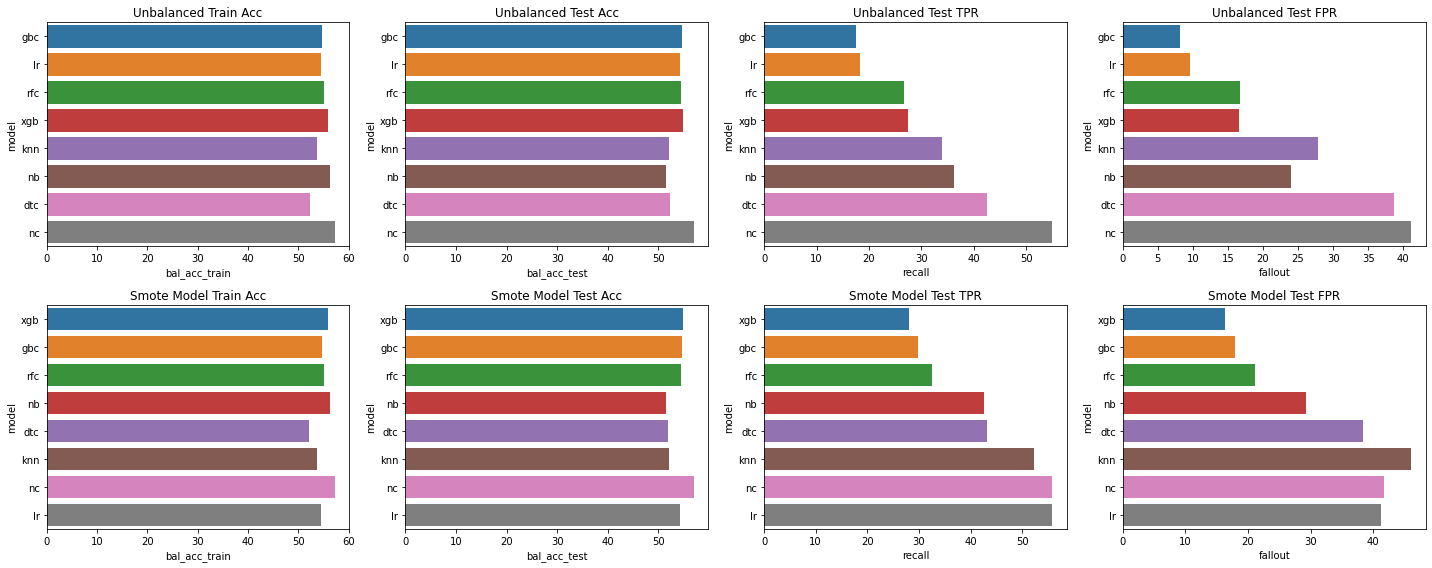

In [61]:
fig, ax = plt.subplots(2,4, figsize=(20, 8))

sns.barplot(x="bal_acc_train", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,3])
ax[0,3].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,3])
ax[1,3].set_title("Smote Model Test FPR")

plt.tight_layout()
plt.show()

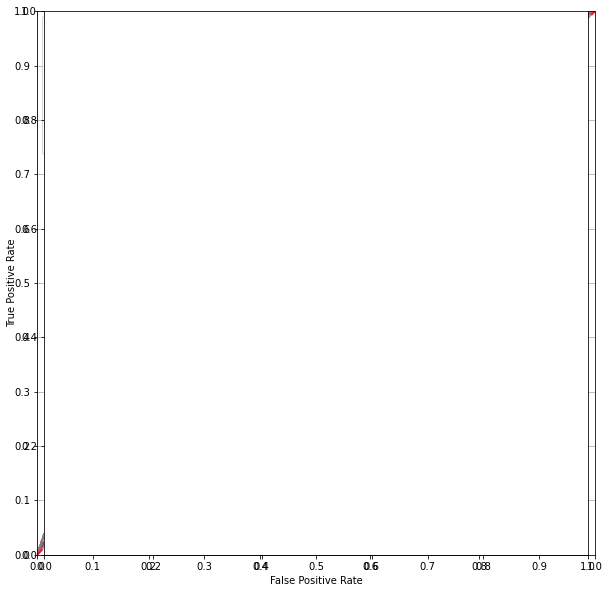

In [62]:
plot_ROC()

GradientBoosting yielded the optimized result as better FPR and relative mean strong recall scores. The balance accuracy is also relatively good.

## Iteration 3: (with RUS)

In [63]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, NearMiss

In [64]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = under_sampler.fit_sample(X_train, y_train)

AttributeError: 'RandomUnderSampler' object has no attribute 'fit_sample'

In [ ]:
ax = y_train_rus.value_counts().plot.bar(color=["blue", "red"])
labels(ax)
plt.show()

#### Use Algorithm

In [ ]:
cv_acc_rus_train = {}
cv_acc_rus_test = {}
cv_TPR_rus = {}
cv_FPR_rus = {}
cv_AUC_rus = {}

In [ ]:
def plot_result_rus(model, name:str):
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores_train = cross_val_score(model, X_train, y_train, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_rus_train[name] = round(scores_train.mean(), 4)*100  # balanced accuracy
    cv_acc_rus_test[name] = round(scores_test.mean(), 4)*100  # balanced accuracy
    cv_TPR_rus[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_rus[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    
    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()

In [ ]:
# Decision tree
dtc = DecisionTreeClassifier()

plot_result_rus(dtc, "dtc")

In [ ]:
# Logistic Regression
lr = LogisticRegression()
plot_result_rus(lr, "lr")

In [ ]:
# NearestCentroid
nc = NearestCentroid()
plot_result_rus(nc, "nc")

In [ ]:
# # SVC
# svc = SVC()
# plot_result_rus(svc, "svc")

In [ ]:
# Random Forest
rfc = RandomForestClassifier()
plot_result_rus(rfc, "rfc")

In [ ]:
# Gradient Boost
gbc = GradientBoostingClassifier(random_state=42)
plot_result_rus(gbc, "gbc")

In [ ]:
# Naive Bayes
nb = GaussianNB()
plot_result_rus(nb, "nb")

In [ ]:
# kNN
knn = KNeighborsClassifier()
plot_result_rus(knn, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss",random_state=42)
plot_result_rus(xgb, "xgb");

In [ ]:
cv_AUC_rus = AUC(cv_AUC_rus)

In [ ]:
df_eval_rus = pd.DataFrame(data={'model': list(cv_acc_rus_train.keys()), 
                             'bal_acc_train':list(cv_acc_rus_train.values()),
                             'bal_acc_test': list(cv_acc_rus_test.values()), 
                             'recall': list(cv_TPR_rus.values()), 
                             'fallout':list(cv_FPR_rus.values()),
                             'AUC': list(cv_AUC_rus.values())}).round(2)    
df_eval_rus

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(20, 12))

sns.barplot(x="bal_acc_train", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,3])
ax[0,3].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,3])
ax[1,3].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("RUS_Featured Model Test Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("RUS_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("RUS_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,3])
ax[2,3].set_title("RUS_Featured Model Test FPR")

plt.tight_layout()
plt.show()

In [ ]:
plot_ROC()

## Iteration 4: (with SMOTE and PCA)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA().fit(X_train_os)

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
xi = np.arange(0, 54, step=1)
y = np.cumsum(pca.explained_variance_ratio_[0:160:1])

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='.', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 54, step=2), rotation=90) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

It looks like n_components = 43 is suitable for% 95 total explained variance,

In [ ]:
pca = PCA(n_components=43)
pca.fit(X_train_os)
per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
labels = ['PC' + str(x) for x in range(1,len(per_var)+1)]

plt.figure(figsize=(20,6))
plt.bar(x=range(len(per_var)), height=per_var, tick_label=labels)
plt.title('Total explained variance {}'.format(np.round(sum(per_var),2)))
plt.ylabel('Explained variance in percent')
plt.xticks(rotation=90)
plt.show()

In [ ]:
X_train_os_pca = pca.transform(X_train_os)
pd.DataFrame(X_train_os_pca)

The loads (loading scores) indicate "how high a variable X loads on a factor Y". 

(The i-th principal components can be selected via i in pca.components_ [0].)

In [ ]:
# Top 20 columns that have the greatest impact
loading_scores = pd.Series(pca.components_[0], index=X.columns)
loading_scores.abs().sort_values(ascending=False)[:20]

#### Use Algorithm

In [ ]:
X_test_pca = pca.transform(X_test)

In [ ]:
cv_acc_balance_train_pca = {}
cv_acc_balance_test_pca = {}
cv_TPR_balance_pca = {}
cv_FPR_balance_pca = {}
cv_AUC_balance_pca = {}

In [ ]:
def plot_result_smoted_pca(model, name:str):
    model.fit(X_train_os_pca, y_train_os)
    y_pred = model.predict(X_test_pca)

    # Evaluation based on a 10-fold cross-validation
    scoring = ['balanced_accuracy', 'recall_macro']
    scores_train = cross_val_score(model, X_train_os_pca, y_train_os, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test_pca, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_train_pca[name] = round(scores_train.mean(), 4)*100  # balanced accuracy
    cv_acc_balance_test_pca[name] = round(scores_test.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_pca[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_pca[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)

    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_pca, y_test)
    plt.show()

In [ ]:
# Decision tree
dtc = DecisionTreeClassifier()
plot_result_smoted_pca(dtc, "dtc")

In [ ]:
# Logistic Regression
lr = LogisticRegression()
plot_result_smoted_pca(lr, "lr")

In [ ]:
# NearestCentroid
nc = NearestCentroid()
plot_result_smoted_pca(nc, "nc")

In [ ]:
# # SVC
# svc = SVC()
# plot_result_smoted_pca(svc, "svc")

In [ ]:
# Random Forest
rfc = RandomForestClassifier()
plot_result_smoted_pca(rfc, "rfc")

In [ ]:
# Gradient Boost
gbc = GradientBoostingClassifier()
plot_result_smoted_pca(gbc, "gbc")

In [ ]:
# Naive Bayes
nb = GaussianNB()
plot_result_smoted_pca(nb, "nb")

In [ ]:
# kNN
knn = KNeighborsClassifier()
plot_result_smoted_pca(knn, "knn")

In [ ]:
# XGBOOST
xgb = XGBClassifier(eval_metric = "logloss")
plot_result_smoted_pca(xgb, "xgb");

In [ ]:
cv_AUC_balance_pca = AUC(cv_AUC_balance_pca, X_test_pca)
cv_AUC_balance_pca

In [ ]:
df_eval_smote_pca = pd.DataFrame(data={'model': list(cv_acc_balance_train_pca.keys()), 
                                       'bal_acc_train':list(cv_acc_balance_train_pca.values()),
                                       'bal_acc_test': list(cv_acc_balance_test_pca.values()),
                                       'recall': list(cv_TPR_balance_pca.values()), 
                                       'fallout':list(cv_FPR_balance_pca.values()),
                                       'AUC': list(cv_AUC_rus.values())}).round(2)
df_eval_smote_pca

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(20, 16))

sns.barplot(x="bal_acc_train", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,3])
ax[0,3].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,3])
ax[1,3].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("RUS_Featured Model Test Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("RUS_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("RUS_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,3])
ax[2,3].set_title("RUS_Featured Model Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,0])
ax[3,0].set_title("Smoted_PCA Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,1])
ax[3,1].set_title("Smoted_PCA Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,2])
ax[3,2].set_title("Smoted_PCA Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,3])
ax[3,3].set_title("Smoted_PCA Model Test FPR")

plt.tight_layout()
plt.show()

In [ ]:
plot_ROC(X_test_pca)

According to Smote and PCA, none of the models really gave relatively good results.

In [ ]:
df_eval["type"] = "Unbalanced"
df_eval_smote["type"] = "Smote"
df_eval_rus["type"] = "RUS"
df_eval_smote_pca["type"] = "Smote_PCA"

In [ ]:
frames = [df_eval, df_eval_smote, df_eval_rus, df_eval_smote_pca]
df_result = pd.concat(frames, ignore_index=True)
df_result['model'] = df_result['model'].str.upper()
df_result[["recall", "fallout", "bal_acc_train", "bal_acc_test",'AUC']] = df_result[["recall", "fallout",  "bal_acc_train", "bal_acc_test",'AUC']].apply(lambda x: np.round(x, 2))

In [ ]:
df_result

In [ ]:
sns.relplot(x="recall", y="AUC", hue="model", size="bal_acc_test", 
            sizes=(40, 400), col="type", alpha=1, palette="bright", height=4, legend='full', data=df_result)

In this plot it looks like GradientBoosting in Smote has a better result

## Iteration 5: (with SMOTE and hyperparameter optimization)

Smote_PCA looks better than Smote. Hyperparameter is optimized by Smote_PCA.

#### GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline

#### Use Algorithm

In [ ]:
cv_acc_balance_PCA_train_tuned = {}
cv_acc_balance_PCA_test_tuned = {}
cv_TPR_balance_PCA_tuned = {}
cv_FPR_balance_PCA_tuned = {}
cv_AUC_balance_PCA_tuned = {}

In [ ]:
def plot_result_smote_pca_tuned(model, name:str):
    model.fit(X_train_os_pca, y_train_os)
    y_pred = model.predict(X_test_pca)

    # Evaluation based on a 10-fold cross-validation
    scores_train = cross_val_score(model, X_train_os_pca, y_train_os, cv=10, scoring = 'balanced_accuracy')
    scores_test = cross_val_score(model, X_test_pca, y_test, cv=10, scoring = 'balanced_accuracy')
    cv_acc_balance_PCA_train_tuned[name] = round(scores_train.mean(), 4)*100  # balanced accuracy
    cv_acc_balance_PCA_test_tuned[name] = round(scores_test.mean(), 4)*100  # balanced accuracy
    cv_TPR_balance_PCA_tuned[name] = (confusion_matrix(y_test, y_pred)[1][1]/confusion_matrix(y_test, y_pred)[1].sum())*100  # recall (max)
    cv_FPR_balance_PCA_tuned[name] = (confusion_matrix(y_test, y_pred)[0][1]/confusion_matrix(y_test, y_pred)[0].sum())*100  # fallout (min)
    
    # accuracy scores
    print('Average Balanced Accuracy (CV=10), Test Set:', scores_test.mean())  
    print('Average Balanced Accuracy (CV=10), Training Set: ', scores_train.mean())

    # print classification report
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(3,3))
    plot_confusion_matrix(model, X_test_pca, y_test)
    plt.show()

In [ ]:
# Decision Tree
params = {'criterion' : ["gini", "entropy"],
          'max_depth':[2, 5, 10], 
          'min_samples_leaf':[20, 10, 1],
          'min_samples_split':[2, 4, 8]}

grid_searcher = GridSearchCV(DecisionTreeClassifier(), params)
grid_searcher.fit(X_train_os_pca, y_train_os)
dtc = grid_searcher
print(grid_searcher.best_estimator_)
plot_result_smote_pca_tuned(grid_searcher, "dtc")

In [ ]:
# Logistic Regression
params = {'penalty' : ['l1', 'l2'],
          'C' : np.logspace(-4, 4, 10),
          'max_iter':[200, 300],
          'solver' : ['liblinear']}

grid_searcher = GridSearchCV(LogisticRegression(), params)
grid_searcher.fit(X_train_os_pca, y_train_os)
lr = grid_searcher
print(grid_searcher.best_estimator_)
plot_result_smote_pca_tuned(grid_searcher.best_estimator_, "lr")

In [ ]:
# NearestCentroid
params={'metric': ['euclidean', 'manhattan'],
        'shrink_threshold' : [0.01, 0.1, 0.5]}

grid_searcher = GridSearchCV(NearestCentroid(), params)
grid_searcher.fit(X_train_os_pca, y_train_os)
nc = grid_searcher
print(grid_searcher.best_estimator_)
plot_result_smote_pca_tuned(grid_searcher.best_estimator_, "nc")

In [ ]:
# # SVC
# params = {'kernel':(['linear','rbf']), 
#           'C':[0.01,1,10], 
#           'gamma':[0.01, 0.1, 1]}

# grid_searcher = GridSearchCV(SVC(), params)
# grid_searcher.fit(X_train_os, y_train_os)
# svc = grid_searcher
# print(grid_searcher.best_estimator_)
# plot_result_smote_pca_tuned(grid_searcher.best_estimator_, "svc")

In [ ]:
# Random Forest
params={'criterion': ['entropy', 'gini'],
        'n_estimators' : [10,50,100],
        'max_features' : [5,15,25]}

grid_searcher = GridSearchCV(RandomForestClassifier(), params)
grid_searcher.fit(X_train_os_pca, y_train_os)
rfc = grid_searcher
print(grid_searcher.best_estimator_)

In [ ]:
plot_result_smote_pca_tuned(grid_searcher.best_estimator_, "rfc")

In [ ]:
# Gradient Boosting Classifier

params={
       "learning_rate": [1],
      "min_samples_split": [50, 10, 2],
       "min_samples_leaf": [1, 5, 10],
       "max_depth":[3,4,5],
       "subsample":[0.5, 1.0],
       "n_estimators":[10, 50, 100],
       "random_state":[42]}

grid_searcher = RandomizedSearchCV(GradientBoostingClassifier(), params, n_iter=10)
grid_searcher.fit(X_train_os_pca, y_train_os)
gbc = grid_searcher
print(grid_searcher.best_estimator_)
plot_result_smote_pca_tuned(gbc, "gbc")

In [ ]:
# Naive Bayes has no tuning
nb = GaussianNB()
plot_result_smote_pca_tuned(nb, "nb")

In [ ]:
# kNN
params = {'n_neighbors':[2, 3, 5],
         'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_searcher = GridSearchCV(KNeighborsClassifier(), params)
grid_searcher.fit(X_train_os_pca, y_train_os)
knn = grid_searcher
print(grid_searcher.best_estimator_)
plot_result_smote_pca_tuned(grid_searcher.best_estimator_, "knn")

In [ ]:
# XGBOOST
params = {"n_estimators": [100, 300],
          "subsample":[0.5,0.8,1],
          "max_depth":[15,25],
          "learning_rate":[0.01,0.1,0.3]}

grid_searcher = GridSearchCV(XGBClassifier(), params)
grid_searcher.fit(X_train_os_pca, y_train_os)
xgb = grid_searcher
print(grid_searcher.best_estimator_)
plot_result_smote_pca_tuned(grid_searcher.best_estimator_, "xgb")

# xgb = XGBClassifier(eval_metric = "logloss",n_estimators=25, learning_rate=0.01,  max_depth=3, random_state=42)
# plot_result_smote_pca_tuned(xgb, "xgb");

In [ ]:
cv_AUC_balance_PCA_tuned = AUC(cv_AUC_balance_PCA_tuned)

In [ ]:
df_eval_smote_pca_tuned = pd.DataFrame(data={'model': list(cv_acc_balance_PCA_train_tuned.keys()), 
                                               'bal_acc_train':list(cv_acc_balance_PCA_train_tuned.values()),
                                               'bal_acc_test': list(cv_acc_balance_PCA_test_tuned.values()),
                                               'recall': list(cv_TPR_balance_PCA_tuned.values()), 
                                               'fallout':list(cv_FPR_balance_PCA_tuned.values()),
                                                'AUC': list(cv_AUC_balance_PCA_tuned.values())}).round(2)
df_eval_smote_pca_tuned

In [ ]:
fig, ax = plt.subplots(5,4, figsize=(20, 20))

sns.barplot(x="bal_acc_train", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,1])
ax[0,1].set_title("Unbalanced Test Acc")
sns.barplot(x="recall", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,2])
ax[0,2].set_title("Unbalanced Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval.sort_values(by="recall"), ax=ax[0,3])
ax[0,3].set_title("Unbalanced Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,0])
ax[1,0].set_title("Smote Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,1])
ax[1,1].set_title("Smote Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,2])
ax[1,2].set_title("Smote Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote.sort_values(by="recall"), ax=ax[1,3])
ax[1,3].set_title("Smote Model Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,0])
ax[2,0].set_title("RUS_Featured Model Test Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,1])
ax[2,1].set_title("RUS_Featured Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,2])
ax[2,2].set_title("RUS_Featured Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_rus.sort_values(by="recall"), ax=ax[2,3])
ax[2,3].set_title("RUS_Featured Model Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,0])
ax[3,0].set_title("Smoted_PCA Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,1])
ax[3,1].set_title("Smoted_PCA Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,2])
ax[3,2].set_title("Smoted_PCA Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca.sort_values(by="recall"), ax=ax[3,3])
ax[3,3].set_title("Smoted_PCA Model Test FPR")

sns.barplot(x="bal_acc_train", y="model", data=df_eval_smote_pca_tuned.sort_values(by="recall"), ax=ax[4,0])
ax[4,0].set_title("Smoted_PCA_Tuned Model Train Acc")
sns.barplot(x="bal_acc_test", y="model", data=df_eval_smote_pca_tuned.sort_values(by="recall"), ax=ax[4,1])
ax[4,1].set_title("Smoted_PCA_Tuned Model Test Acc")
sns.barplot(x="recall", y="model", data=df_eval_smote_pca_tuned.sort_values(by="recall"), ax=ax[4,2])
ax[4,2].set_title("Smoted_PCA_Tuned Model Test TPR")
sns.barplot(x="fallout", y="model", data=df_eval_smote_pca_tuned.sort_values(by="recall"), ax=ax[4,3])
ax[4,3].set_title("Smoted_PCA_Tuned Model Test FPR")

plt.tight_layout()
plt.show()

In [ ]:
df_eval_smote_pca_tuned["type"] = "Smote_PCA_Tuned"

In [ ]:
frames = [df_eval, df_eval_smote, df_eval_rus, df_eval_smote_pca, df_eval_smote_pca_tuned]
df_result = pd.concat(frames, ignore_index=True)
df_result['model'] = df_result['model'].str.upper()
df_result[["recall", "fallout", "bal_acc_train", "bal_acc_test",'AUC']] = df_result[["recall", "fallout",  "bal_acc_train", "bal_acc_test",'AUC']].apply(lambda x: np.round(x, 2))
df_result

In [ ]:
sns.relplot(x="recall", y="AUC", hue="model", size="bal_acc_test", 
            sizes=(40, 400), col="type", alpha=1, palette="bright", height=5, legend='full', data=df_result)

The tunned GradientBoost Model didnt give a better result.

#  Summary: 
* In this project the diabetic_data.csv dataset was analyzed by machine learning methods with 5 iterations as a classification. For each iteration one tried little by little to achieve a better model result. 
* 8 different algorithms (DecisionTree, Logistic Regression, Random Forest, Gradient Boost, NaiveBayes, Nearest Centroid, XGBOOST and kNearestNeigbour) were used. 
* After the data cleaning and EDA process, the data set was scaled with StandartScaler because there were many large and small features. After that, something special (oversampling, FeatureSelection, FeatureExtraction, HyperParameter optimization) was applied in each iteration. 
* In the end, GradientBoost with only undersampled and scaled data set gave better results.